In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, isnan, count
from src.utils.s3_manager import S3Manager
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import os

nltk_data_dir = 'nltk_data'

if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)
  
nltk.data.path.append(nltk_data_dir)
nltk.download('stopwords', download_dir=nltk_data_dir)

[nltk_data] Downloading package stopwords to nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

This is a simple EDA to have a better understanding of the data.
We will use Spark for loading the data and Pandas for visualization and plots

In [63]:

data_dir = "/Users/ilan/big-data-airflow-project/data"

In [64]:
spark = SparkSession.builder \
    .appName("EDA with Spark") \
    .getOrCreate()

In [65]:
df = spark.read.parquet(data_dir+"/NetflixDataset.parquet", header=True, inferSchema=True)

In [66]:
df.show(50000)

+--------------------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+-------------+-------------------+--------------------+--------------------+-------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               Title|               Genre|                Tags|           Languages|Country Availability|     Runtime|            Director|              Writer|              Actors|  View Rating|         IMDb Score|     Awards Received|Awards Nominated For|    Boxoffice|Release Date|Netflix Release Date|    Production House|        Netflix Link|             Summary|     Series or Movie|          IMDb Votes|               Image|
+--------------------+--------------------+--------------------+--------------------+--------------------+------------+---------------

In [67]:
df.printSchema()

root
 |-- Title: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Languages: string (nullable = true)
 |-- Country Availability: string (nullable = true)
 |-- Runtime: string (nullable = true)
 |-- Director: string (nullable = true)
 |-- Writer: string (nullable = true)
 |-- Actors: string (nullable = true)
 |-- View Rating: string (nullable = true)
 |-- IMDb Score: string (nullable = true)
 |-- Awards Received: string (nullable = true)
 |-- Awards Nominated For: string (nullable = true)
 |-- Boxoffice: string (nullable = true)
 |-- Release Date: string (nullable = true)
 |-- Netflix Release Date: string (nullable = true)
 |-- Production House: string (nullable = true)
 |-- Netflix Link: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Series or Movie: string (nullable = true)
 |-- IMDb Votes: string (nullable = true)
 |-- Image: string (nullable = true)


In [68]:
print("The shape of the netflix dataset is ", (df.count(), len(df.columns)))

The shape of the netflix dataset is  (4297, 22)


# Dealing with missing values

We will look at each column to see how to manage missing values

In [69]:
missing_values = df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns])
missing_values.show()

+-----+-----+----+---------+--------------------+-------+--------+------+------+-----------+----------+---------------+--------------------+---------+------------+--------------------+----------------+------------+-------+---------------+----------+-----+
|Title|Genre|Tags|Languages|Country Availability|Runtime|Director|Writer|Actors|View Rating|IMDb Score|Awards Received|Awards Nominated For|Boxoffice|Release Date|Netflix Release Date|Production House|Netflix Link|Summary|Series or Movie|IMDb Votes|Image|
+-----+-----+----+---------+--------------------+-------+--------+------+------+-----------+----------+---------------+--------------------+---------+------------+--------------------+----------------+------------+-------+---------------+----------+-----+
|    0|    6|  24|       21|                   8|      1|     865|   554|    19|        642|         2|           1554|                1012|     1897|          78|                   0|            1616|           0|      0|          

#### Drop Director, tags, country_availibility, writer, ViewRating, Awards Received, Awards Nominated For, BoxOffice, Netflix Release Date, Production House, Netflix Link, IMDB votes, Image columns

We will drop the columns above

In [70]:

df = df.drop(
 "Tags", 
 "Languages", 
 "Country Availability", 
 "Director", "Writer", "View Rating", "Awards Received","Awards Nominated","Boxoffice", "Netflix Release Date", "Production House", "Netflix Link", "IMDb Votes", "Image", "Awards Nominated For", "Release Date")

In [71]:
df.show()

+--------------------+--------------------+------------+--------------------+----------+--------------------+---------------+
|               Title|               Genre|     Runtime|              Actors|IMDb Score|             Summary|Series or Movie|
+--------------------+--------------------+------------+--------------------+----------+--------------------+---------------+
|          Ishq Vishk|     Comedy, Romance|     > 2 hrs|Amrita Rao, Shena...|         6|When the duplicit...|          Movie|
|          Liars Dice|Adventure, Drama,...|    1-2 hour|Vikram Bhagra, Ma...|       6.9|A woman from a sm...|          Movie|
|Reggie Yates Extreme|         Documentary|< 30 minutes|        Reggie Yates|       7.7|Award-winning fil...|         Series|
|Akashic Record of...|Animation, Action...|< 30 minutes|Josh Grelle, Moni...|       7.1|A jaded, lazy sub...|         Series|
|Its Only the End ...|               Drama|    1-2 hour|L�a Seydoux, Mari...|       6.9|A gay man returns...|         

#### Runtime column

In [72]:
df.groupby("runtime").count().orderBy("count", ascending=False).show()

+------------+-----+
|     runtime|count|
+------------+-----+
|    1-2 hour| 2509|
|< 30 minutes|  949|
|     > 2 hrs|  790|
|  30-60 mins|   48|
|        NULL|    1|
+------------+-----+


We don't want to change the runtime column, this column is already categorical.

In [73]:
df = df.fillna({'runtime': '1-2 hour'})


#### Imdb score column

Since the rating columns of allocine dataset is /5. We will normalize the rating column to be /5

In [74]:
from pyspark.sql.types import FloatType
from pyspark.sql.functions import col, round as spark_round

df = df.withColumn("IMDb Score", col("IMDb Score").cast(FloatType()))
df = df.withColumn("IMDb Score", spark_round(col("IMDb Score") / 2, 1))


In [75]:
df.show()

+--------------------+--------------------+------------+--------------------+----------+--------------------+---------------+
|               Title|               Genre|     Runtime|              Actors|IMDb Score|             Summary|Series or Movie|
+--------------------+--------------------+------------+--------------------+----------+--------------------+---------------+
|          Ishq Vishk|     Comedy, Romance|     > 2 hrs|Amrita Rao, Shena...|       3.0|When the duplicit...|          Movie|
|          Liars Dice|Adventure, Drama,...|    1-2 hour|Vikram Bhagra, Ma...|       3.5|A woman from a sm...|          Movie|
|Reggie Yates Extreme|         Documentary|< 30 minutes|        Reggie Yates|       3.8|Award-winning fil...|         Series|
|Akashic Record of...|Animation, Action...|< 30 minutes|Josh Grelle, Moni...|       3.5|A jaded, lazy sub...|         Series|
|Its Only the End ...|               Drama|    1-2 hour|L�a Seydoux, Mari...|       3.5|A gay man returns...|         

We replace each missing value by the mean of the column

In [76]:
from pyspark.sql.functions import mean

In [77]:
mean_value = df.select(mean(col("IMDb Score")).alias("mean")).collect()[0]["mean"]
df = df.na.fill({"IMDb Score": mean_value})

In [78]:
df.show()

+--------------------+--------------------+------------+--------------------+----------+--------------------+---------------+
|               Title|               Genre|     Runtime|              Actors|IMDb Score|             Summary|Series or Movie|
+--------------------+--------------------+------------+--------------------+----------+--------------------+---------------+
|          Ishq Vishk|     Comedy, Romance|     > 2 hrs|Amrita Rao, Shena...|       3.0|When the duplicit...|          Movie|
|          Liars Dice|Adventure, Drama,...|    1-2 hour|Vikram Bhagra, Ma...|       3.5|A woman from a sm...|          Movie|
|Reggie Yates Extreme|         Documentary|< 30 minutes|        Reggie Yates|       3.8|Award-winning fil...|         Series|
|Akashic Record of...|Animation, Action...|< 30 minutes|Josh Grelle, Moni...|       3.5|A jaded, lazy sub...|         Series|
|Its Only the End ...|               Drama|    1-2 hour|L�a Seydoux, Mari...|       3.5|A gay man returns...|         

#### Rename Series or Movies

In [79]:
df = df.withColumnRenamed("Series or Movie", "Type")

# Plots

For plotting, we will use pandas. We will then convert the spark dataframe to pandas dataframe.

In [80]:
pandas_df = df.toPandas() 
pandas_df.head()

,Title,Genre,Runtime,Actors,IMDb Score,Summary,Type
0,Ishq Vishk,"Comedy, Romance",> 2 hrs,"Amrita Rao, Shenaz Treasury, Shahid Kapoor, Vi...",3.0,When the duplicitous Rajiv expresses his love ...,Movie
1,Liars Dice,"Adventure, Drama, Family",1-2 hour,"Vikram Bhagra, Manya Gupta, Nawazuddin Siddiqu...",3.5,A woman from a small mountain village disobeys...,Movie
2,Reggie Yates Extreme,Documentary,< 30 minutes,Reggie Yates,3.8,Award-winning filmmaker Reggie Yates travels a...,Series
3,Akashic Record of Bastard Magic Instructor,"Animation, Action, Comedy, Fantasy",< 30 minutes,"Josh Grelle, Monica Rial, Rachael Messer, Morg...",3.5,"A jaded, lazy substitute teacher takes over a ...",Series
4,Its Only the End of the World,Drama,1-2 hour,"L�a Seydoux, Marion Cotillard, Vincent Cassel,...",3.5,A gay man returns to his family after a 12-yea...,Movie


/var/folders/bg/rn6v3_d90s7b47lrzgg2ds0c0000gn/T/ipykernel_13813/3926704042.py:1 FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

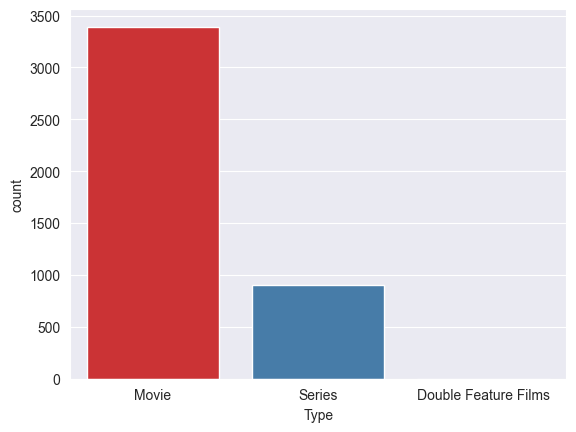

In [81]:
ax = sns.countplot(x="Type", data=pandas_df, palette="Set1")

### ImdB Score distribution

[2024-05-18T20:10:49.439+0200] {category.py:223} INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


/var/folders/bg/rn6v3_d90s7b47lrzgg2ds0c0000gn/T/ipykernel_13813/177316272.py:2 FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

[2024-05-18T20:10:49.455+0200] {category.py:223} INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


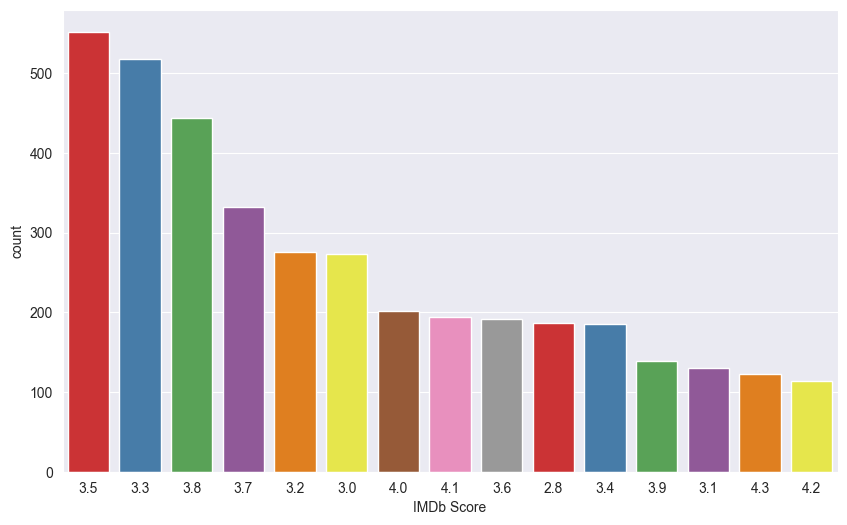

In [82]:
plt.figure(figsize=(10,6))
sns.countplot(x="IMDb Score", legend=False,data=pandas_df, palette="Set1",  order=pandas_df['IMDb Score'].value_counts().index[0:15])
plt.show()

## EDA NLP

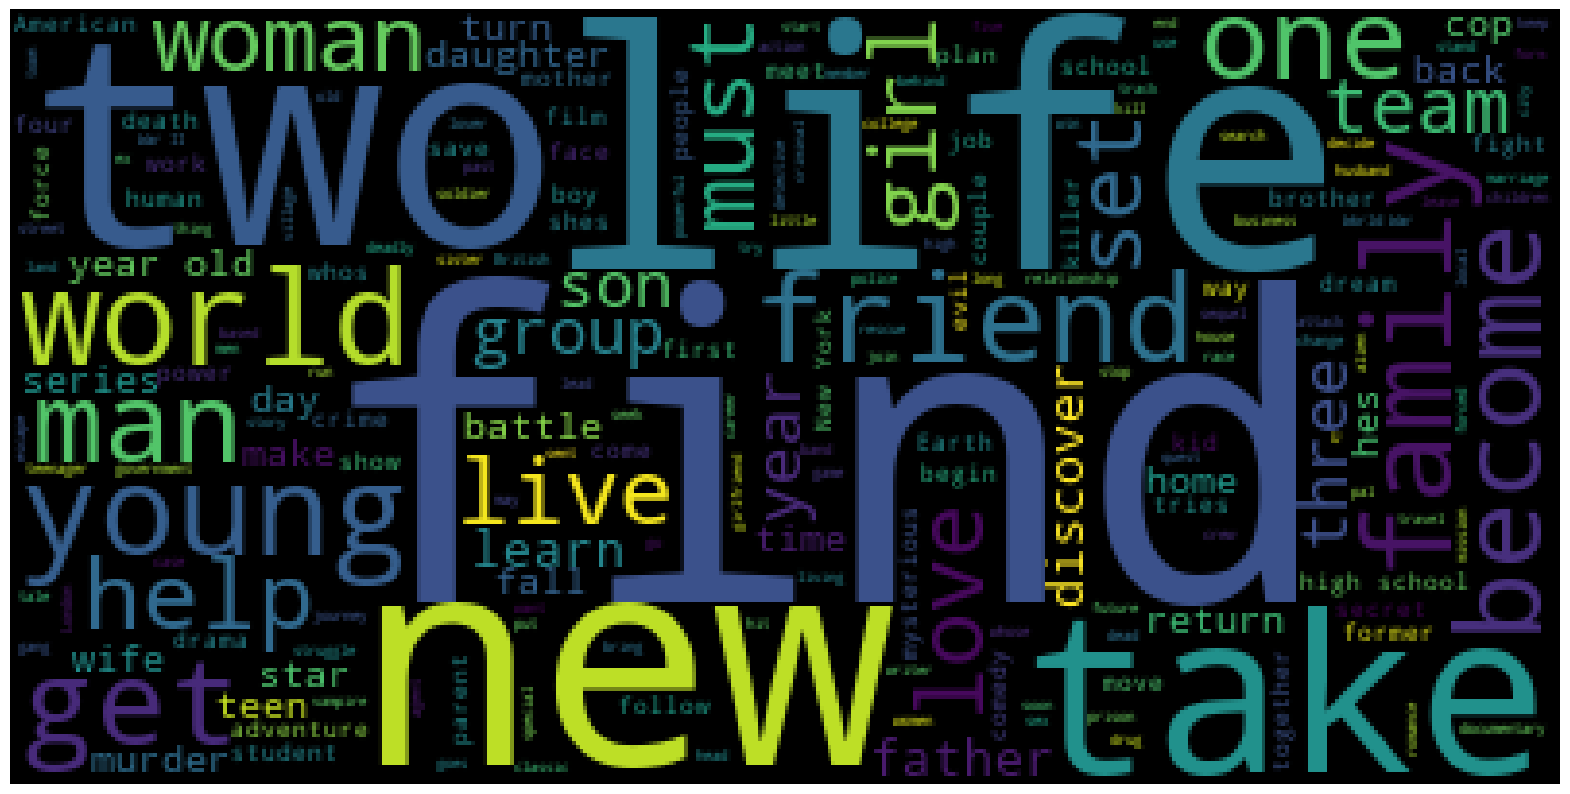

In [83]:
stop_words = set(stopwords.words('english'))
plt.figure(figsize=(20,20))
wordcloud = WordCloud(background_color = 'black', stopwords = stop_words).generate(" ".join(pandas_df.Summary))

plt.imshow(wordcloud)
plt.axis("off")
plt.show();